In [2]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from bayesian_optimization.evaluate_BN import Eval_BN
from igraph import *
import networkx as nx
from collections import Counter

from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re

p = os.path.join("vertex_4_6dim_latent_KL0.01_NObatch_hs64","final_structures6_1")
vis_path = os.path.join(p, "evaluation")
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)



In [3]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
print(ix)
# print(df5.iloc[[300]])


369


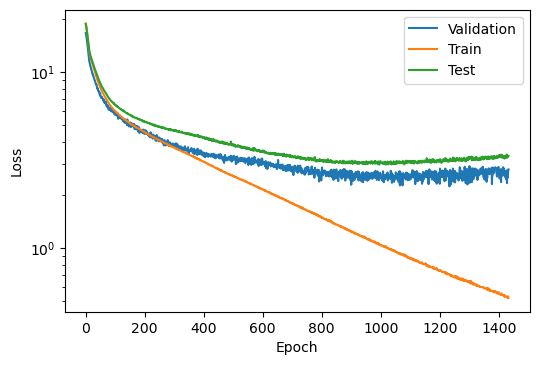

In [30]:
plt.figure(dpi = 100)

plt.plot(df5.iloc[:,3], label='Validation')
plt.plot(df5.iloc[:,0], label='Train')
plt.plot(df5.iloc[:,4], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
# plt.plot(df3.iloc[:2949,4], label='Total')

In [5]:


args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)


cuda:0


In [6]:
graph_args = DotMap()
graph_args.max_n = 6
graph_args.num_vertex_type = 6
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

cuda:0


In [7]:
all_data = []
all_data2 = []
train_data = []
test_data = []

for filename in os.listdir("..\\graph_data\\vertex_4_new"):
    path = os.path.join("..\\graph_data\\vertex_4_new", filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(6)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['type']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[5]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data2.append(graph2)
print(all_data[0].vs["type"])
print(all_data[1].vs["type"])
print(len(all_data))

[0, 2, 3, 4, 5, 1]
[0, 2, 3, 5, 4, 1]
543


In [7]:

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
latest_checkpoint = max(files, key= os.path.getctime)
print(latest_checkpoint)
latest_checkpoint_filename = Path(latest_checkpoint).name
print(latest_checkpoint_filename)
last_epoch = re.findall(r'\d+', latest_checkpoint_filename)
print(last_epoch[0])

# q = 563
# latest_checkpoint = os.path.join(model_dir,"model_checkpoint"+str(q)+".pth")
# print(latest_checkpoint)
load_module_state(model,latest_checkpoint)



vertex_4_6dim_latent_KL0.01_NObatch_hs64\final_structures6_1\model
vertex_4_6dim_latent_KL0.01_NObatch_hs64\final_structures6_1\model\model_checkpoint1235.pth
model_checkpoint1235.pth
1235


In [8]:
latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
for data in all_data:
    mu, _ = model.encode(data)
    mu = mu.cpu().detach().numpy()
    latents.append(mu)
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(5, 'in')
    max_degree = np.max(data.vs.degree())
    in_degree = np.max(data.vs.indegree())
    out_degree = np.max(data.vs.outdegree())
    zero_pred =  len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "in") == [0]])    
    zero_succ = len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "out") == [5]])
    
    minus_edges = len(null_edges) + len(end_edges)
    mu  = np.append(mu, data.ecount()- minus_edges)
    mu  = np.append(mu, max_degree)
    mu  = np.append(mu, in_degree)
    mu  = np.append(mu, out_degree)
    mu  = np.append(mu, zero_pred)
    mu  = np.append(mu, zero_succ)




    
    extended.append(mu)

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

(543, 1, 6)


In [9]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [[ 0.21025698  0.36397332  0.90127826 -0.6325035  -0.37310147 -0.04884741]]
Z_std: [[1.7135147 1.0549122 1.1257596 1.0833465 1.4550662 1.2327782]]
Z norm: 79.5616


<class 'numpy.ndarray'>


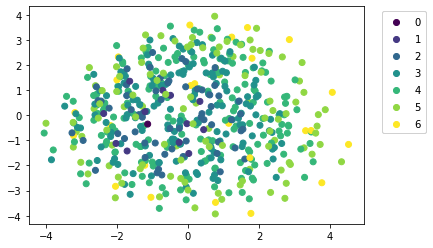

In [10]:
a = latents.reshape((543,args.nz))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))

fig, ax = plt.subplots(facecolor=(1, 1, 1))
scatter = ax.scatter(components[:,0], components[:,1], c=extended[:,args.nz])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
fig_name = os.path.join(vis_path, "all_data_encoded")
fig.savefig(fig_name,bbox_inches='tight')
plt.show()



In [11]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 1000
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid


valid, invalid, Zs_valid, Zs_invalid = prior_validity()
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]

8467
1533


Interpolation experiments around a great circle
2
z0:  tensor([[-0.7652,  1.1798, -0.4271,  0.0690, -0.6244, -0.1430]],
       device='cuda:0', grad_fn=<AddmmBackward0>) z1:  tensor([[ 0.6879,  0.6879, -0.4571,  0.6879,  0.6879,  0.6879]],
       device='cuda:0', grad_fn=<MulBackward0>) dot product:  2.9802322387695312e-08
norm of z0: 1.6046732664108276, norm of z1: 1.604673147201538
distance between z0 and z1: 2.26935076713562
angle between z0 and z1: 1.570796251296997


Check validity for 10/11: 100%|██████████| 11/11 [00:00<00:00, 687.29it/s]
Latent point 10's most common decoding ratio: 1/1: 100%|██████████| 11/11 [00:00<00:00, 578.76it/s]


IGRAPH D--T 6 6 --
+ attr: type (v)
+ edges:
0->1 1->2 1->3 3->4 2->5 4->5


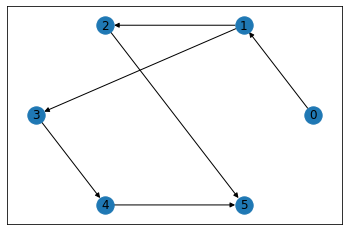

IGRAPH D--T 6 5 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 3->4 4->5


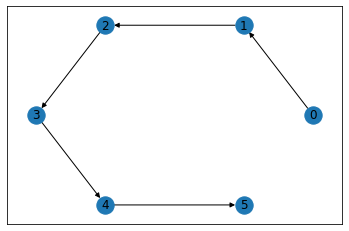

IGRAPH D--T 6 6 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 2->4 3->5 4->5


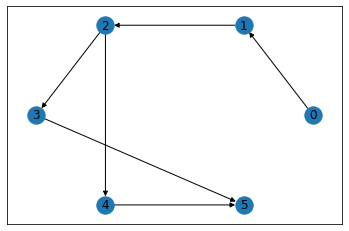

IGRAPH D--T 6 5 --
+ attr: type (v)
+ edges:
0->2 2->3 3->4 1->5 4->5


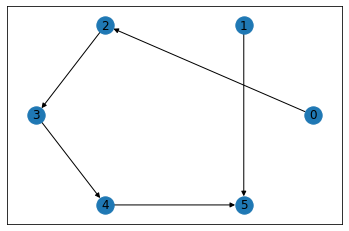

IGRAPH D--T 6 7 --
+ attr: type (v)
+ edges:
0->1 0->2 0->3 3->4 1->5 2->5 4->5


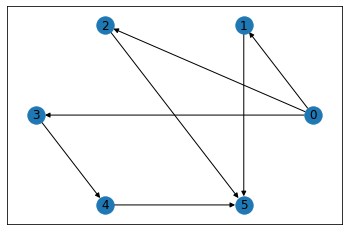

IGRAPH D--T 6 7 --
+ attr: type (v)
+ edges:
0->1 0->2 0->3 3->4 1->5 2->5 4->5


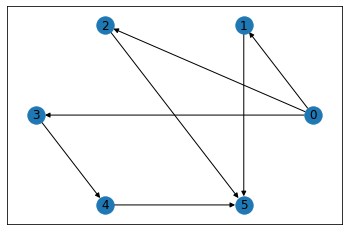

IGRAPH D--T 6 6 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 3->4 2->4 4->5


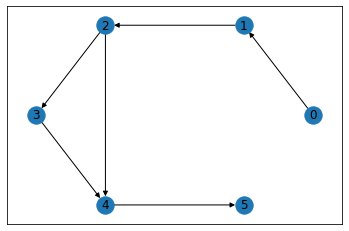

IGRAPH D--T 6 5 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 3->4 4->5


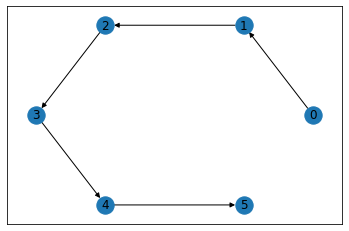

IGRAPH D--T 6 6 --
+ attr: type (v)
+ edges:
0->1 1->2 1->3 3->4 2->5 4->5


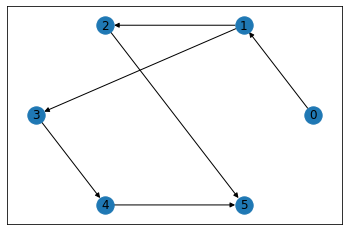

IGRAPH D--T 6 5 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 3->4 4->5


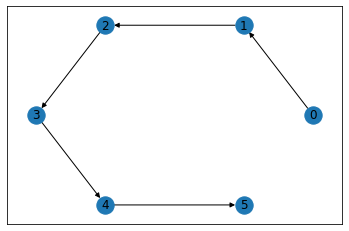

Valid decoded graphs: 10


In [36]:
# felpakolni layoutra, átírni start és end type jelét/ törölni source és end node-ot
def interpolation_exp3(model,data):
    print('Interpolation experiments around a great circle')
    interpolate_number = 10
    model.eval()
    g_ix = random.randint(0,len(data))
    g0 =  data[g_ix]
    z0, _ = model.encode(g0)
    norm0 = torch.norm(z0)
    z1 = torch.ones_like(z0)
    # there are infinite possible directions that are orthogonal to z0,
    # we just randomly pick one from a finite set
    dim_to_change = random.randint(0, z0.shape[1]-1)  # this to get different great circles
    print(dim_to_change)
    z1[0, dim_to_change] = -(z0[0, :].sum() - z0[0, dim_to_change]) / z0[0, dim_to_change]
    z1 = z1 / torch.norm(z1) * norm0
    print('z0: ', z0, 'z1: ', z1, 'dot product: ', (z0 * z1).sum().item())
    print('norm of z0: {}, norm of z1: {}'.format(norm0, torch.norm(z1)))
    print('distance between z0 and z1: {}'.format(torch.norm(z0-z1)))
    omega = torch.acos(torch.dot(z0.flatten(), z1.flatten()))
    print('angle between z0 and z1: {}'.format(omega))
    Z = []  # to store all the interpolation points
    for j in range(0, interpolate_number + 1):
        theta = 2*math.pi / interpolate_number * j
        zj = z0 * np.cos(theta) + z1 * np.sin(theta)
        Z.append(zj)
    Z = torch.cat(Z, 0)
    # decode many times and select the most common one
    G, _ = decode_from_latent_space(latent_points=Z,model= model,decode_attempts=1, return_igraph=True, data_type=args.data_type) 
    
    g_cnt = 0
    for g_j in G:
        if g_j is not None:
            g_cnt+=1
            print(g_j)
            g_x = g_j.to_networkx()
            pos = nx.circular_layout(g_x)
            nx.draw_networkx(g_x, pos=pos)
            plt.show()
    print("Valid decoded graphs: "+ str(g_cnt))
interpolation_exp3(model,all_data)



In [ ]:
def visualize_recon(epoch):
    model.eval()
    # draw some reconstructed train/test graphs to visualize recon quality
    for i, g in enumerate(test_data[:1]):
        if args.model.startswith('SVAE'):
            g = g.to(device)
            g = model._collate_fn(g)
            g_recon = model.encode_decode(g)[0]
            g = model.construct_igraph(g[:, :, :model.nvt], g[:, :, model.nvt:], False)[0]
        elif args.model.startswith('DVAE'):
            g_recon = model.encode_decode(g)[0]
        name0 = 'graph_epoch{}_id{}_original'.format(epoch, i)

        save0 =  os.path.join(args.fig_dir, name0)
        g_x = g.to_networkx()
        nx.draw_networkx(g_x)
        plt.show()
        plt.savefig(save0)
        plt.close()
        name1 = 'graph_epoch{}_id{}_recon'.format(epoch, i)
        save1 = os.path.join(args.fig_dir, name1)
        g_x_recon = g_recon.to_networkx()
        nx.draw_networkx(g_x_recon)
        plt.show()
        plt.savefig(save1)
        plt.close()

torch.Size([1, 6])


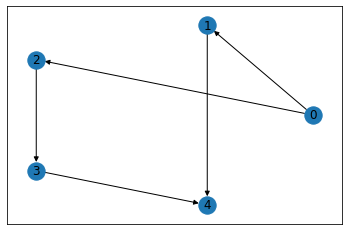

torch.Size([1, 6])


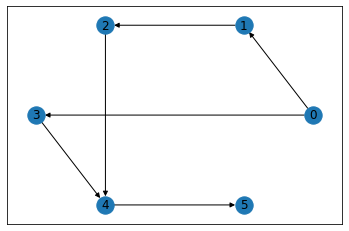

torch.Size([1, 6])


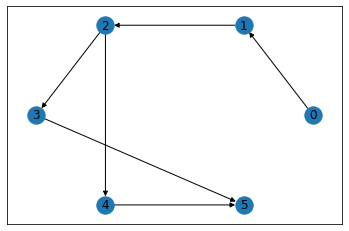

torch.Size([1, 6])


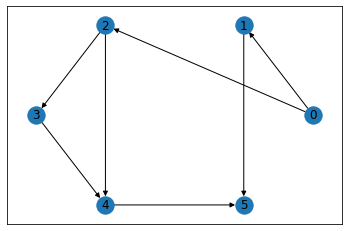

torch.Size([1, 6])


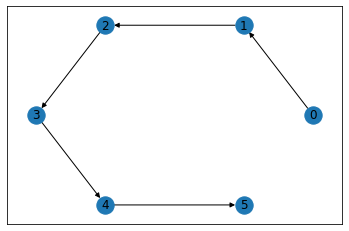

torch.Size([1, 6])


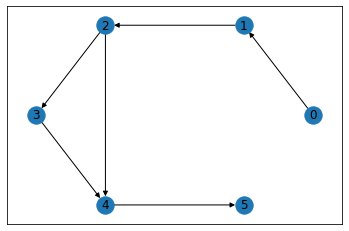

(6, 1, 6)
[ 0.78305113  0.8188141  -0.98610365 -0.45333248  0.7575426  -2.2615154 ]
[ 0.7825933   0.61505353 -0.6268933  -0.5603458   0.46009973 -1.8848873 ]
[ 0.7821355   0.41129303 -0.2676829  -0.66735923  0.16265684 -1.5082593 ]
[ 0.7816776   0.20753247  0.09152746 -0.7743726  -0.13478601 -1.1316311 ]
[ 0.7812198   0.00377196  0.45073783 -0.8813859  -0.43222892 -0.7550031 ]
[ 0.78076196 -0.19998854  0.8099482  -0.9883993  -0.72967184 -0.37837505]
[1.6053110e+00 1.0859382e-07]
[ 9.6318656e-01 -4.2661700e-08]
[ 3.210622e-01 -4.926024e-08]
[-3.2106215e-01  4.5015174e-08]
[-9.6318656e-01  3.7828929e-08]
[-1.6053107e+00  4.1444380e-08]


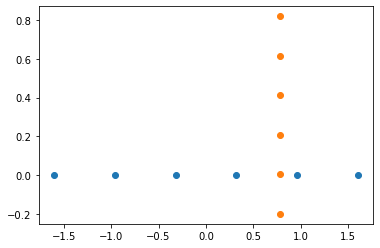

In [19]:
# dim = 6
# z_std = np.random.rand(1,dim)
# z_mean = np.random.rand(1,dim)
# print(z_std)
# print(z_mean)
def interpolate1(n_split):
    z1 = torch.randn(1,model.nz).to(model.get_device())
    z2 = torch.randn(1,model.nz).to(model.get_device())
    Z_train = latents
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    z_mean, z_std = torch.FloatTensor(z_mean).to(model.get_device()), torch.FloatTensor(z_std).to(model.get_device())
    z1 = z1 * z_std + z_mean
    z2 = z2 * z_std + z_mean
    z_diff = (z1-z2)/n_split
    points = []
    for i in range(n_split+1):
        offset = z_diff*i
        c_z = offset+z2
        print(c_z.size())
        points.append(c_z.cpu().detach().numpy())
        g = model.decode(c_z)
        g_x = g[0].to_networkx()
        pos = nx.circular_layout(g_x)

        nx.draw_networkx(g_x, pos=pos)
        plt.show()

    points = np.array(points)
    print(np.shape(points))
    points = points.reshape((n_split+1,args.nz))
    pca = PCA(n_components=2)
    components = pca.fit_transform(points)
    plt.scatter(components[:,0], components[:,1])
    plt.scatter(points[:,0], points[:,1])
    for point in points:
        print(point)
    for component in components:
        print(component)
    return components


comp2 = interpolate1(5)


In [ ]:
# dim = 6
# z_std = np.random.rand(1,dim)
# z_mean = np.random.rand(1,dim)
# print(z_std)
# print(z_mean)
def interpolate2(n_split):
    z1 = torch.randn(1,model.nz).to(model.get_device())
    z2 = torch.randn(1,model.nz).to(model.get_device())
    Z_train = latents
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    z_mean, z_std = torch.FloatTensor(z_mean).to(model.get_device()), torch.FloatTensor(z_std).to(model.get_device())
    z1 = z1 * z_std + z_mean
    z2 = z2 * z_std + z_mean
    z_diff = (z1-z2)/n_split
    points = []
    for i in range(n_split+1):
        offset = z_diff*i
        c_z = offset+z2
        print(c_z.size())
        points.append(c_z.cpu().detach().numpy())
        # g = model.decode(c_z)
        g, _ = decode_from_latent_space(c_z,model,500,'variable',True, 'BN')
        g_x = g[0].to_networkx()
        nx.draw_networkx(g_x)
        plt.show()
    points = np.array(points)
    print(np.shape(points))
    points = points.reshape((n_split+1,args.nz))
    pca = PCA(n_components=2)
    components = pca.fit_transform(points)
    plt.scatter(components[:,0], components[:,1])
    plt.scatter(points[:,0], points[:,1])
    for point in points:
        print(point)
    for component in components:
        print(component)
    return components


# comp2 = interpolate1(5)


In [ ]:
def interpolation_exp3():
    print('Interpolation experiments around a great circle')
    interpolation_res_dir = os.path.join(args.res_dir, 'interpolation3')
    if not os.path.exists(interpolation_res_dir):
        os.makedirs(interpolation_res_dir) 
    interpolate_number = 36
    model.eval()
    g_ix = random.randint(0,len(all_data))
    g0 =  all_data[g_ix]
    z0, _ = model.encode(g0)
    norm0 = torch.norm(z0)
    z1 = torch.ones_like(z0)
    # there are infinite possible directions that are orthogonal to z0,
    # we just randomly pick one from a finite set
    dim_to_change = random.randint(0, z0.shape[1]-1)  # this to get different great circles
    print(dim_to_change)
    z1[0, dim_to_change] = -(z0[0, :].sum() - z0[0, dim_to_change]) / z0[0, dim_to_change]
    z1 = z1 / torch.norm(z1) * norm0
    print('z0: ', z0, 'z1: ', z1, 'dot product: ', (z0 * z1).sum().item())
    print('norm of z0: {}, norm of z1: {}'.format(norm0, torch.norm(z1)))
    print('distance between z0 and z1: {}'.format(torch.norm(z0-z1)))
    omega = torch.acos(torch.dot(z0.flatten(), z1.flatten()))
    print('angle between z0 and z1: {}'.format(omega))
    Z = []  # to store all the interpolation points
    for j in range(0, interpolate_number + 1):
        theta = 2*math.pi / interpolate_number * j
        zj = z0 * np.cos(theta) + z1 * np.sin(theta)
        Z.append(zj)
    Z = torch.cat(Z, 0)
    # decode many times and select the most common one
    G, _ = decode_from_latent_space(latent_points=Z,model= model,decode_attempts=1, return_igraph=True, data_type=args.data_type) 
    for j in range(0, interpolate_number + 1):
        g_x = G[j].to_networkx()
        nx.draw_networkx(g_x)
        plt.show()
    # draw figures with the same height

# interpolation_exp3()

In [ ]:
if(len(invalid) > 0):
    print(invalid[0])
    print(invalid[0].vs["type"])

In [20]:
print(len(all_data))
print(len(valid))
valid2 = valid.copy()
for g in all_data2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

for g in valid2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

543
8467


In [21]:
def is_same_DAG2(g0, g1):
    # note that it does not check isomorphism
    if g0.vcount() != g1.vcount():
        return False
    if set(g0.vs["type"]) != set(g1.vs["type"]):
        return False
    if g0.ecount() != 0 or g1.ecount() == 0:
        for vi in range(g0.vcount()):
            g0_index_of_type = g0.vs.find(type=vi+2)
            g1_index_of_type = g1.vs.find(type=vi+2)
            # g0_vs = g0.vs[g0_index_of_type]
            # g1_vs = g1.vs[g1_index_of_type]

            # if g0.vs[vi]['type'] != g1.vs[vi]['type']:
            #     return False
            g0_neighbours = set([g0.vs[vs_i]["type"] for vs_i in g0.neighbors(g0_index_of_type, 'in')])
            g1_neighbours = set([g1.vs[vs_i]["type"] for vs_i in g1.neighbors(g1_index_of_type, 'in')])
            if g0_neighbours != g1_neighbours:
                return False
    return True

In [52]:
g = all_data[0]
a = g.vs["type"]
print(a)
a.sort()
print(a)

# separator = 0
# nodeTypes = g.vs["type"]
# nodeTypes.sort()
# nodeTypes.append(0)
# neighbourhoods = [nodeTypes]
# for type in nodeTypes:
#     indexOfType = g.vs.find(type = type)
#     neighbours = [g.vs[vs_i]["type"] for vs_i in g.neighbors(indexOfType, 'in')]
#     neighbours.sort()
#     neighbours.append(0)
#     neighbourhoods.append(neighbours)
# r2 = [str(item) for sublist in neighbourhoods for item in sublist ]
# r3 = "".join(r2)
nodeTypes = sorted(g.vs["type"])
n2 =  "".join([str(nodeType) for nodeType in nodeTypes + [0]] + [str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])




print(n2)
# print(r3)
 




[0, 2, 3, 4, 5, 1]
[0, 1, 2, 3, 4, 5]
012345005000202302340


In [22]:
decode_ix = []
for v_ix,v in enumerate(valid2) :
    for d_ix,d in enumerate(all_data2):
        if is_same_DAG2(v,d):
            decode_ix.append(d_ix)
            break
        
print(len(decode_ix))
print()



8467



In [26]:
import collections
counter = collections.Counter(decode_ix)
c_values = list(counter.values())
print(c_values)
print(np.max(c_values))


[74, 60, 7, 17, 15, 36, 49, 10, 11, 2, 54, 16, 24, 5, 44, 50, 9, 52, 35, 43, 75, 23, 19, 56, 58, 27, 24, 17, 27, 51, 12, 49, 13, 55, 14, 68, 61, 14, 12, 5, 19, 59, 14, 20, 59, 13, 42, 64, 11, 35, 27, 8, 3, 28, 18, 27, 83, 25, 16, 9, 23, 6, 30, 22, 11, 13, 26, 46, 1, 14, 12, 14, 12, 7, 3, 9, 16, 18, 2, 29, 18, 10, 33, 62, 34, 1, 25, 24, 12, 26, 10, 29, 40, 12, 1, 50, 87, 40, 36, 13, 57, 30, 26, 23, 33, 14, 20, 41, 55, 29, 20, 5, 136, 60, 122, 56, 7, 16, 9, 7, 54, 22, 12, 11, 12, 43, 52, 5, 65, 4, 6, 17, 7, 15, 17, 18, 70, 17, 23, 7, 70, 32, 7, 24, 9, 17, 13, 9, 51, 3, 47, 1, 36, 31, 13, 40, 20, 34, 5, 18, 24, 20, 136, 40, 14, 6, 25, 20, 2, 10, 30, 5, 56, 7, 18, 23, 2, 45, 50, 32, 25, 5, 47, 25, 15, 20, 2, 15, 6, 43, 17, 72, 18, 4, 2, 12, 8, 19, 1, 5, 23, 1, 8, 13, 4, 68, 11, 42, 21, 14, 2, 2, 18, 32, 3, 6, 54, 24, 17, 11, 24, 4, 17, 61, 31, 10, 30, 5, 3, 10, 6, 63, 6, 4, 13, 4, 3, 11, 5, 43, 31, 3, 7, 19, 7, 22, 67, 14, 36, 13, 9, 6, 13, 14, 18, 3, 3, 23, 8, 13, 4, 16, 2, 6, 5, 21, 11, 

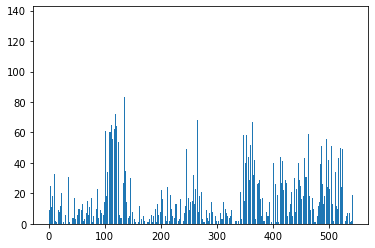

In [23]:
hist1 = np.histogram(decode_ix, bins=543)
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [ ]:
uni = np.random.randint(0,542,len(decode_ix))
uni2 = np.random.randint(0,542,len(decode_ix))
m_mean =np.mean(hist1[0])
m_median =np.median(hist1[0])
m_std = np.std(hist1[0])
m_max = np.max(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0])
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, last_epoch[0], args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid)])



In [ ]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

In [ ]:
from scipy import stats
print(stats.mode(decode_ix))

(8467, 6)


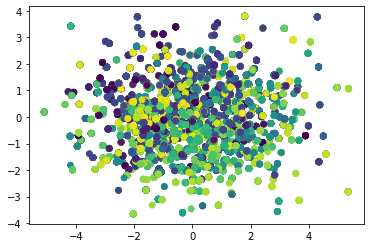

In [27]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=decode_ix)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

361
136
136


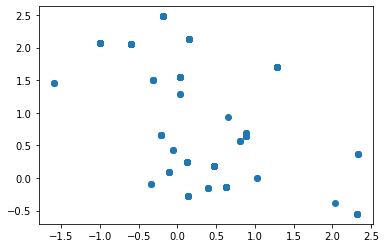

In [28]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(decode_ix)) if decode_ix[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])

(1533, 6)


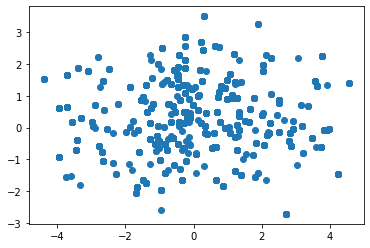

In [29]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])